In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="sigmoid")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
    )
    return agent

In [8]:
#safe learning   
l = 5.
step = 200000  # num of interval
episode_step = step
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"], action_lr=0.001, tau_lr=0.000001)
a.actor.load_weights('./saved_agent/self_trigger_split.h5')
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 132s 13ms/step - reward: 8.3341e-05
Interval 2 (10000 steps performed)
10000/10000 [==============================] - 156s 16ms/step - reward: 2.4686e-04
Interval 3 (20000 steps performed)
 2149/10000 [=====>........................] - ETA: 2:02 - reward: 5.1075e-04done, took 322.088 seconds


4.5647178922081366e-05
9.13345575099811e-05
0.0001370622958347667
0.00018283039025845937
0.00022863887352286838
0.00027448787295725197
0.0003203773776476737
0.0003663074239739217
0.0004122781319892965
0.0004582895417115651
0.0005043416458647698
0.0005504345645022113
0.0005965682939859107
0.0006427429580071475
0.0006889585456519853
0.0007352151405939367
0.0007815127755748108
0.0008278514869743958
0.0008742313621041831
0.0009206524773617275
0.0009671148218330927
0.0010136184791917913
0.0010601634858176112
0.0011067499690398108
0.0011533779215824325
0.0012000473761872854
0.001246758420165861
0.0012935110862599686
0.0013403054581431206
0.0013871415321773384
0.0014340194284159224
0.0014809391395829152
0.001527900793007575
0.0015749044287076686
0.0016219500394072384
0.001669037708779797
0.001716167516860878
0.0017633394527365454
0.0018105536473740358
0.0018578100971353706
0.0019051088820560835
0.0019524500858096872
0.0019998337447759695
0.0020472598989726976
0.002094728628435405
0.0021422399

0.02490274703814066
0.0249600844726956
0.025017445204866817
0.025074829241930274
0.025132236485660542
0.0251896670597489
0.025247120967833325
0.025304598162620096
0.025362098658661125
0.025419622521440033
0.025477169700025115
0.02553474020533031
0.02559233404826955
0.025649951185187092
0.025707591674290597
0.02576525553376996
0.025822942709055496
0.025880653272906784
0.02593838717439212
0.025996144424425438
0.026053925033920677
0.026111729064723477
0.026169556524109794
0.02622740731749218
0.026285281506716274
0.026343179099058034
0.026401100054499693
0.026459044431248913
0.026517012189287925
0.02657500333589269
0.026633017932908842
0.02669105588211096
0.02674911730355234
0.02680720214630128
0.026865310370340012
0.02692344209572184
0.026981597275153035
0.027039775919547537
0.02709797792340396
0.027156203410413582
0.02721445238785236
0.027272724812064553
0.027331020690326113
0.02738934003718896
0.027447682856291067
0.027506049103976693
0.02756443889666116
0.027622852136119036
0.027681288

0.05222677750498406
0.05229459255861002
0.05236243199396995
0.05243029576013214
0.05249818379888893
0.05256609611751628
0.05263403272329015
0.052701993630762445
0.05276997891269275
0.0528379885108734
0.05290602236709674
0.05297408048863872
0.05304216295553488
0.05311026977506117
0.053178400889009936
0.05324655630465713
0.05331473609476234
0.05338294014291023
0.05345116852186038
0.053519421173405135
0.053587698170304066
0.05365599945434951
0.05372432504009339
0.05379267493481166
0.05386104908029665
0.05392944754930795
0.05399787034912151
0.05406631742880563
0.05413478879563627
0.054203284522372996
0.05427180448532454
0.054340348822734086
0.05440891747639398
0.05447751039537252
0.054546127594221616
0.05461476913842489
0.054683434897015104
0.05475212495730375
0.054820839326566784
0.054889578070287826
0.05495834107205155
0.0550271284118935
0.05509593995884643
0.055164775851153536
0.055233636037883116
0.05530252052631113
0.05537142932371353
0.05544036237188266
0.05550931967809447
0.05557830

0.08752911699048127
0.08760812835316756
0.08768716005943133
0.0877662118182343
0.08784528385513113
0.08792437602460268
0.08800348841396044
0.08808262087768526
0.08816177348853671
0.08824094617375522
0.08832013887513313
0.08839935166543
0.08847858447188628
0.08855783730177791
0.08863711008962127
0.08871640283541637
0.08879571547367959
0.08887504808444646
0.0889544005949574
0.08903377300521242
0.08911316524245194
0.08919257732122787
0.08927200932157575
0.08935146101794089
0.08943093249035883
0.08951042374610552
0.08958993479245692
0.08966946554937749
0.08974901595138363
0.08982858607851085
0.0899081758579996
0.08998778529712581
0.09006741440316546
0.09014706303059938
0.0902267313322227
0.09030641923527583
0.09038612659423961
0.0904658534891496
0.0905456000000413
0.09062536590863601
0.09070515136772883
0.09078495615176507
0.0908647804208158
0.09094462410212145
0.09102448720295797
0.09110436965056579
0.0911842714449449
0.09126419252061169
0.09134413295760169
0.09142409268315532
0.091504071

0.12666327294209623
0.1267498397610325
0.1268364189636486
0.12692301062998013
0.12700961476002703
0.12709623120099423
0.12718286011295277
0.12726950142314308
0.12735615503697773
0.12744282104904414
0.1275294993793068
0.12761619010780123
0.12770289307445637
0.12778960835930775
0.12787633596235537
0.12796307581083965
0.12804982798479614
0.12813659248422482
0.12822336914177868
0.1283101580447692
0.12839695920047234
0.12848377252885257
0.12857059802263393
0.1286574358564394
0.12874428578288644
0.12883114788201055
0.12891802216108772
0.1290049085400824
0.12909180701171863
0.12917871758327237
0.12926564033477916
0.12935257518620347
0.12943952198475017
0.1295264808832144
0.12961345189614804
0.12970043493623962
0.12978742999621318
0.12987443709062063
0.12996145621946198
0.13004848737546126
0.13013553047858295
0.13022258554337895
0.13030965256257332
0.13039673153616604
0.1304838223841216
0.13057092519375146
0.13065803996505565
0.13074516661799862
0.1308323052326159
0.13091945564883645
0.1310066

0.16671414152733632
0.16680528285723994
0.166896432525391
0.1669875906263769
0.16707875698557473
0.16716993178488337
0.16726111483512796
0.16735230623817188
0.1674435058994277
0.16753471391348285
0.1676259301857499
0.16771715481081628
0.16780838770137052
0.16789962885013665
0.1679908782716666
0.16808213595140842
0.16817340190391405
0.16826467612190754
0.16835595852535334
0.16844724928887445
0.1685385482305719
0.16862985544503317
0.16872117084494676
0.16881249451762415
0.16890382629571832
0.16899516633930034
0.16908651457561064
0.16917787091006176
0.16926923552455264
0.16936060832449584
0.16945198931716732
0.16954337850256707
0.1696347757933836
0.1697261811896169
0.16981759486589
0.1699090166548558
0.1700004465492384
0.17009188464362524
0.17018333084342885
0.1702747851559252
0.17036624757383834
0.1704577181917557
0.17054919682777836
0.17064068358376971
0.17073217845972977
0.1708236813537951
0.17091519236782915
0.17100671149455593
0.17109823865393992
0.17118977383870515
0.171281317143439

0.21036780476788408
0.21046223803205066
0.21055667723339866
0.21065112237192807
0.2107455734621908
0.21084003040959942
0.21093449329418945
0.21102896212323685
0.21112343689674162
0.21121791744008078
0.21131240393515327
0.21140689637468313
0.21150139475867036
0.21159589900707942
0.21169040928725735
0.21178492533726967
0.21187944733173936
0.21197397518335492
0.21206850889939233
0.21216304856716306
0.21225759417939116
0.2123521456560411
0.2124467029098014
0.21254126602070755
0.2126358350760711
0.21273040990854497
0.21282499068547622
0.21291957723951782
0.21301416965798126
0.21310876794086653
0.21320337217548513
0.21329798218721407
0.21339259806336486
0.21348721980393748
0.21358184740165598
0.21367648087107227
0.21377112021218636
0.21386576532313484
0.2139604163057811
0.21405507305826177
0.21414973567516427
0.21424440407645307
0.2143390783421637
0.21443375838498469
0.214528444204916
0.21462313589654514
0.2147178333652846
0.21481253661113442
0.21490724573595799
0.2150019606378919
0.21509668

0.25662271256078384
0.25671973632779554
0.25681676509339013
0.2569137986683927
0.2570108371473907
0.25710788063224754
0.25720492901382386
0.2573019822993956
0.2573990404889628
0.25749610358980135
0.2575931716892228
0.25769024459805223
0.25778732250546454
0.2578844053168723
0.2579814930395514
0.258078585666226
0.258175683196896
0.2582727856388374
0.2583698929847742
0.25846700533656985
0.25856412250504945
0.2586612445775245
0.2587583714739594
0.2588555032743898
0.25895263997881557
0.25904978159451275
0.2591469282160688
0.2592440796615847
0.2593412360038201
0.2594383972646028
0.25953556343665696
0.2596327345127065
0.25972991050730343
0.2598270913113083
0.25992427703386056
0.26002146757309674
0.26011866311819176
0.2602158634799707
0.26031306867298554
0.26041027886458323
0.2605074937782774
0.26060471361051896
0.2607019382667204
0.2607991679215047
0.2608964024002489
0.2609936417975405
0.2610908861061034
0.2611881353332137
0.26128538937700796
0.26138264815017465
0.2614799118418887
0.261577180

0.3031441927123524
0.3032434287779324
0.30334266928912257
0.3034419142531988
0.3035411636628851
0.30364041752545745
0.3037396758336399
0.3038389385874325
0.3039382056995237
0.30403747725722496
0.30413675326053635
0.30423603362214635
0.30433531853122986
0.304434607791336
0.30453390159163973
0.304633199757518
0.3047325023690064
0.30483180943338084
0.30493112084877794
0.30503043681164854
0.3051297571400937
0.30522908181956154
0.30532841095191543
0.3054277445371554
0.305527082473418
0.3056264249571541
0.30572577189377625
0.30582512318869703
0.3059244789365039
0.3060238390426093
0.3061232035070134
0.3062225725261669
0.30632194590361905
0.30642132382126874
0.30652070609721704
0.30662009273146396
0.3067194838258729
0.3068188792785804
0.30691827919145
0.30701768346261815
0.307117092084809
0.3072165051671618
0.30731592270967667
0.3074153446177661
0.3075147709714656
0.30761420159615227
0.3077136367683124
0.30781307630604715
0.3079125203912554
0.3080119688420382
0.30811142165839556
0.308210878833

0.34621521405279054
0.34631628980787355
0.34641736961566494
0.3465184535634762
0.3466195416513074
0.34672063389371033
0.34682173027613317
0.3469228307112644
0.3470239352864155
0.34712504400886246
0.3472261568858812
0.34732727380105644
0.3474283948635275
0.34752952008057036
0.34763064934304566
0.34773178274554084
0.34783292020802037
0.34793406181779574
0.348035207567591
0.3481363574646821
0.3482375113198941
0.348338669322402
0.3484398315740691
0.34854099787116866
0.34864216822825256
0.3487433427326323
0.3488445212824445
0.34894570398682845
0.34904689083850826
0.3491480817356205
0.34924927678730455
0.34935047588442103
0.3494516790487978
0.34955288625860703
0.34965409771029954
0.3497553132219764
0.34985653288822505
0.3499577566944936
0.3500589845534705
0.35016021647970774
0.35026145245865337
0.3503626925776189
0.3504639367638447
0.35056518509736634
0.3506664375854598
0.35076769412626163
0.35086895471977186
0.3509702194678539
0.3510714882759203
0.35117276113669504
0.35127403814476565
0.351

0.39334033452541917
0.39344324422927457
0.3935461577602837
0.3936490751184465
0.39375199619462364
0.39385492120709387
0.3939578500467178
0.3940607827134954
0.39416371920742677
0.3942666594266484
0.39436960347302374
0.39447255135382875
0.39457550306178746
0.39467845849503647
0.39478141776271514
0.3948843808575475
0.39498734788867296
0.3950903186450887
0.39519329312679474
0.39529627154479385
0.3953992536953592
0.3955022396730783
0.39560522947795107
0.39570822310997755
0.3958112205764337
0.3959142217754561
0.39601722680890816
0.3961202356767899
0.3962232482699619
0.39632626469028764
0.3964292848504556
0.39653230883777724
0.39663533665952855
0.3967383682138461
0.39684140360259335
0.3969444428184943
0.3970474858688249
0.39715053265172173
0.39725358316718484
0.3973566375243536
0.3974596958105394
0.3975627577274281
0.39766582347874646
0.39776889296990703
0.3978719663900847
0.39797504354282864
0.3980781244354148
0.39818120915515465
0.39828429760746076
0.3983873897996091
0.3984904858189111
0.39

0.44452544737941935
0.44463016356530716
0.4447348832436546
0.4448396064217377
0.444944332997693
0.44504906316069537
0.44515379682343337
0.445258533978631
0.4453632747354277
0.445468018984684
0.4455727667264
0.44567751796057564
0.4457822725926235
0.44588703082627035
0.44599179255237686
0.44609655777094304
0.4462013264965208
0.4463060987145582
0.4464108744323312
0.44651565364256385
0.44662043645439553
0.44672522265682346
0.4468300122571236
0.44693480545902275
0.44703960225524497
0.4471444024493394
0.4472492062377569
0.44735401343132253
0.4474588242264872
0.4475636384122481
0.44766845599588123
0.4477732771738374
0.4478781018515292
0.4479829300289566
0.44808776170611964
0.44819259678115486
0.4482974354577891
0.448402277626883
0.4485071232957125
0.4486119723696902
0.4487168249434035
0.4488216811187158
0.4489265406919003
0.449031403662957
0.44913627013374935
0.4492411401042773
0.44934601357454085
0.449450890551816
0.4495557710288267
0.4496606548964337
0.44976554237291566
0.4498704333418573
0

0.493799575324374
0.4939058646305057
0.49401215718171443
0.4941184529780003
0.4942247520193632
0.4943310542985273
0.4944373598227685
0.4945436684974993
0.49464998041730723
0.49475629558219225
0.49486261387573904
0.4949689354216389
0.49507526021261583
0.49518158824866987
0.4952879194279376
0.4953942539541458
0.4955005916308437
0.49560693253806676
0.49571327659577946
0.49581962400043267
0.49592597454829956
0.4960323283339676
0.4961386853719887
0.49624504555322346
0.4963514089868113
0.49645777565820026
0.4965641454728029
0.49667051853975863
0.4967768948445155
0.49688327439434943
0.49698965700008557
0.49709604284362285
0.49720243203410064
0.4973088244769315
0.49741522005570005
0.49752161878495826
0.49762802076656953
0.49773442588411854
0.4978408342540206
0.4979472458617238
0.4980536606271926
0.4981600786304625
0.4982664997842221
0.49837292429219815
0.4984793519433879
0.4985857826359279
0.49869221658082097
0.49879865366165177
0.49890509409669903
0.49901153778409935
0.49911798461471335
0.499

0.5472268979319779
0.547334725062683
0.5474425551838067
0.5475503881789336
0.5476582240553398
0.5477660629076126
0.5478739047503041
0.5479817495688621
0.5480895972686994
0.5481974478570919
0.548305301421351
0.5484131579687528
0.5485210173901578
0.548628879700118
0.5487367448840814
0.5488446130584634
0.5489524842087121
0.549060358247516
0.5491682352621865
0.5492761151654122
0.5493839980445046
0.5494918837976002
0.5495997725411144
0.5497076641586318
0.5498155587665678
0.5499234562485071
0.5500313566190016
0.5501392599726387
0.5502471660984156
0.5503550752146111
0.5504629873139493
0.5505709021854273
0.5506788200473238
0.5507867407832236
0.5508946646186814
0.5510025913281424
0.5511105209188827
0.5512184533981781
0.5513263887514768
0.5514343270879181
0.5515422684147779
0.551650212622917
0.5517581597123353
0.5518661096757569
0.551974062636873
0.5520820184792683
0.5521899770938035
0.5522979387060332
0.5524059033014055
0.5525138707707811
0.5526218412232993
0.5527298144697852
0.5528377906994137

0.597892262008827
0.598001399779605
0.5981105401551758
0.5982196833392663
0.5983288290262863
0.5984379775218258
0.5985471286148822
0.5986562823127315
0.5987654388263763
0.5988745980394015
0.5989837598644954
0.5990929242798302
0.5992020914090972
0.5993112612377445
0.599420433780324
0.5995296090295597
0.5996387867744488
0.5997479672332702
0.5998571503914718
0.5999663362636056
0.6000755248351197
0.6001847160114266
0.6002939098943898
0.6004031064840092
0.6005123056711454
0.6006215074703505
0.6007307119689358
0.6008399190795899
0.6009491288896243
0.6010583414135908
0.6011675565350743
0.6012767743704899
0.6013859949125617
0.6014952180594264
0.6016044439129473
0.601713672371261
0.6018229034270917
0.6019321372041304
0.6020413736805494
0.6021506128709007
0.6022598546660447
0.602369099160569
0.6024783462671621
0.6025875959712721
0.6026968483893143
0.6028061034121492
0.6029153611343645
0.6030246214686485
0.6031338845095888
0.6032431501625979
0.6033524185222632
0.6034616894794453
0.603570963048696

0.6473769586191338
0.647487249927508
0.6475975435569126
0.6477078397037985
0.647818138164439
0.6479284392517002
0.6480387427618552
0.6481490486949042
0.6482593570435711
0.6483696678151318
0.6484799810023105
0.6485902967142465
0.6487006148418004
0.6488109353922482
0.6489212582637265
0.6490315836526861
0.6491419114645396
0.6492522418011504
0.649362574560655
0.6494729096266383
0.6495832472246548
0.6496935871291498
0.6498039295656781
0.6499142744178243
0.6500246216928645
0.6501349713835225
0.6502453234970744
0.6503556780262443
0.650466034985584
0.6505763942586782
0.6506867560565297
0.6507971201754117
0.650907486811775
0.6510178557618929
0.651128227244044
0.651238601141813
0.6513489774624759
0.6514593561987567
0.6515697373652074
0.6516801210564154
0.6517905070613779
0.6519008955910977
0.6520112864418479
0.6521216797082161
0.6522320753902022
0.6523424736114976
0.6524528741392714
0.6525632770972152
0.6526736824707768
0.6527840903690958
0.6528945005884452
0.653004913332552
0.6531153283976892
0

0.7004765992860484
0.7005880017059098
0.7006994064613536
0.7008108133413771
0.7009222224478435
0.701033633788029
0.7011450473546574
0.7012564631550049
0.7013678810872079
0.70147930125313
0.7015907235363557
0.7017021480533003
0.7018135746948246
0.701925003562792
0.7020364346644783
0.7021478679998836
0.7022593034671445
0.7023707411681244
0.7024821810955473
0.7025936231475498
0.7027050674332713
0.7028165138362965
0.70292796258218
0.7030394134526432
0.703150866447686
0.7032623216691718
0.7033737791243766
0.7034852387187129
0.7035967006413557
0.7037081645867147
0.7038196307657927
0.7039310990694503
0.7040425697159662
0.7041540424870618
0.704265517382737
0.7043769945048552
0.7044884738606925
0.7045999553411093
0.7047114390552451
0.7048229250031
0.7049344130755344
0.7050459032725485
0.7051573957032815
0.7052688903677335
0.7053803871567652
0.7054918860703765
0.7056033872177068
0.705714890598756
0.7058263961043849
0.7059379038437328
0.7060494137076603
0.7061609258053068
0.7062724400275329
0.706

0.7537447831819009
0.7538571812510781
0.7539695812556602
0.7540819832975103
0.7541943873693526
0.7543067932674603
0.7544192012028361
0.7545316111754801
0.7546440230762528
0.7547564370142936
0.7548688528731873
0.754981270783901
0.7550936906154675
0.7552061123751628
0.7553185361721262
0.7554309619044943
0.7555433896741306
0.7556558193718956
0.7557682511069288
0.7558806846682273
0.7559931203613814
0.7561055579972162
0.7562179976703192
0.7563304392642749
0.7564428828954988
0.7565553284548514
0.7566677759568847
0.7567802254961862
0.7568926769563404
0.7570051304537628
0.757117585879314
0.7572300432329939
0.7573425025220786
0.7574549639502948
0.757567427095637
0.7576798922782473
0.7577923594981257
0.757904828646133
0.7580172997368209
0.7581297728647769
0.7582422479208617
0.7583547249050753
0.758467203926557
0.7585796848761674
0.7586921677611826
0.7588046525743266
0.7589171394247387
0.7590296283196949
0.7591421190263645
0.7592546117775782
0.7593671065660601
0.7594796031808073
0.759592101723683

0.8040646880217537
0.8041779275845329
0.80429116887899
0.8044044118978491
0.8045176567429735
0.8046309033197758
0.8047441517373954
0.804857401879417
0.8049706538549799
0.8050839076713601
0.8051971632121422
0.8053104206010175
0.8054236798161583
0.8055369407557009
0.8056502035433368
0.8057634680553747
0.8058767342990905
0.8059900023690716
0.80610327227987
0.8062165439223463
0.806329817391088
0.8064430927079229
0.8065563696400204
0.8066696483983833
0.8067829288884241
0.8068962112192821
0.8070094953836815
0.8071227812724828
0.8072360691185168
0.8073493585798133
0.8074626498746511
0.8075759428938909
0.8076892377612239
0.8078025343529589
0.8079158327782352
0.8080291329351894
0.8081424348165456
0.8082557385314431
0.8083690439780185
0.8084823512654111
0.8085956603863451
0.8087089712316811
0.8088222838086949
0.808935598233802
0.8090489143760351
0.8091622322499461
0.8092755519646744
0.809388873512944
0.8095021966910281
0.8096155216953775
0.8097288484314049
0.8098421770009736
0.8099555073022202
0

0.8569076716121344
0.8570217012056673
0.8571357325381541
0.8572497655077314
0.8573638001071231
0.85747783622719
0.8575918739843473
0.8577059133713192
0.8578199542789662
0.8579339968164277
0.8580480409909796
0.8581620867880702
0.8582761342222511
0.8583901831698313
0.8585042337545019
0.858618285968987
0.8587323397041473
0.8588463949672587
0.8589604519693239
0.8590745104993402
0.8591885707683105
0.8593026325579558
0.8594166959774157
0.8595307610194141
0.8596448275893636
0.8597588957964035
0.859872965633258
0.8599870369907876
0.8601011098762683
0.8602151845007029
0.8603292606530886
0.8604433384280128
0.8605574178327515
0.8606714987581654
0.8607855814298091
0.8608996656221279
0.8610137514442613
0.8611278386924823
0.8612419276796572
0.8613560181802313
0.8614701103178959
0.8615842039835115
0.8616982994899445
0.8618123963060498
0.8619264947519696
0.8620405948349799
0.8621546965478046
0.8622687997885805
0.8623829046518949
0.8624970111450239
0.8626111192752433
0.8627252290352772
0.86283934020684

0.9120496312571049
0.9121643939033675
0.9122791579611658
0.9123939234523277
0.9125086904714408
0.9126234589166415
0.9127382288970693
0.9128530002890329
0.9129677729906689
0.9130825471256685
0.9131973227886192
0.9133120997612423
0.913426878167229
0.9135416581011668
0.9136564394539164
0.9137712222327536
0.9138860063212633
0.914000791945
0.9141155789948243
0.9142303674561845
0.9143451573509083
0.9144599486717198
0.914574741411343
0.9146895355770539
0.9148043312707159
0.9149191282813263
0.9150339268198877
0.9151487266753975
0.9152635280588584
0.9153783307592676
0.9154931347693491
0.9156079403146578
0.9157227472860541
0.9158375556762621
0.9159523655944213
0.9160671768368047
0.9161819896144152
0.9162968037016981
0.9164116192077927
0.9165264362491143
0.9166412547165237
0.9167560744936054
0.9168708958059142
0.9169857184278953
0.9171005424832401
0.9172153679573967
0.9173301949595043
0.9174450233949756
0.9175598531401192
0.9176746843040746
0.9177895168941177
0.9179043509029725
0.9180191864470544

0.964986542963743
0.9651019306293165
0.965217319502699
0.9653327097075817
0.9654481011202733
0.965563493740774
0.9656788877946383
0.9657942830563115
0.9659096796422091
0.966025077545055
0.9661404766557098
0.9662558770905889
0.966371278733277
0.96648668159105
0.9666020858749107
0.9667174914757197
0.9668328982988896
0.9669483064317319
0.9670637156705197
0.9671791263426712
0.9672945382226317
0.9674099514195404
0.9675253658242582
0.9676407815532002
0.9677561984972272
0.9678716168673418
0.9679870364525414
0.9681024573619652
0.968217879479198
0.9683333028115158
0.9684487274535059
0.9685641533105809
0.9686795804918802
0.9687950089901278
0.9689104386961844
0.9690258698356047
0.9691413021828339
0.9692567357378721
0.9693721706244105
0.9694876067187579
0.9696030442464689
0.9697184829819889
0.9698339230344573
0.9699493642947346
0.9700648067628208
0.9701802505624073
0.9702956955698028
0.9704111419086985
0.9705265894554032
0.9706420383190562
0.9707574885069334
0.9708729399098956
0.9709883925206668
0

1.0162245332940074
1.0163404599261412
1.0164563875550812
1.0165723165082454
1.0166882465819072
1.0168041777542385
1.0169201101343788
1.01703604373688
1.0171519784380507
1.017267914259719
1.0173838511800568
1.0174997892063402
1.017615728556848
1.0177316690133011
1.017847610582976
1.0179635533604596
1.018079497243889
1.0181954422405397
1.0183113884449995
1.0184273357481288
1.0185432841717557
1.0186592338031915
1.0187751846569881
1.018891136507591
1.0190070895660028
1.0191230437376362
1.019238999015215
1.0193549553914636
1.0194709130992123
1.0195868719056307
1.0197028318179946
1.01981879284358
1.019934754975111
1.0200507182053116
1.0201666827670124
1.0202826484273828
1.0203986152082507
1.0205145830877882
1.0206305520732712
1.0207465222811152
1.0208624934712134
1.0209784659928118
1.0210944396276318
1.0212104143683973
1.0213263902078324
1.0214423672696284
1.0215583453209547
1.0216743245946418
1.0217903049669985
1.0219062865617161
1.0220222692623793
1.022138253061712
1.0222542379669903
1.022

1.0676887524641643
1.0678051621907798
1.0679215728050622
1.06803798452529
1.0681543973587395
1.0682708110798558
1.0683872259141936
1.0685036418617528
1.068620058689703
1.068736476740014
1.068852895677992
1.068969315620052
1.0690857366607815
1.0692021587055933
1.0693185817472113
1.0694350058947748
1.0695514310536964
1.0696678572021483
1.0697842843546823
1.0699007126204378
1.0700171418829996
1.0701335721496434
1.0702500034058176
1.0703664357752132
1.0704828690322756
1.0705993034025596
1.070715738886065
1.0708321753591008
1.0709486127198034
1.071065051091864
1.0711814905698702
1.071297931146546
1.07141437273458
1.0715308153121441
1.071647258777375
1.0717637033558276
1.0718801490475016
1.0719965956268425
1.0721130433194048
1.0722294920160493
1.0723459417095
1.072462392407033
1.0725788442032353
1.07269529700352
1.072811750917026
1.072928205718199
1.0730446616325935
1.0731611185437941
1.073277576459077
1.0733940352620266
1.0735104951636458
1.0736269561784866
1.0737434180809942
1.073859881096

1.1222768857223855
1.1223937506692891
1.122510616620275
1.1226274834589276
1.122744351192523
1.1228612198210612
1.1229780893445422
1.123094959762966
1.1232118310617807
1.1233287033719535
1.123445576562517
1.1235624505388841
1.1236793256211968
1.1237962013874494
1.1239130781505082
1.1240299560195126
1.1241468346815964
1.1242637141149316
1.1243805946687644
1.1244974759938486
1.1246143582138757
1.1247312414379849
1.1248481255570368
1.124965010672895
1.125081896683696
1.1251987835894397
1.1253156713901262
1.1254325600857555
1.125549449778191
1.125666340241878
1.1257832316005079
1.1259001239632198
1.1260170171117352
1.1261339112643327
1.1262508064137364
1.1263677023489436
1.1264845992882329
1.1266014969987737
1.1267183957133966
1.1268352953229623
1.1269521959293343
1.1270690973287856
1.1271859996159037
1.1273029027979646
1.1274198068604164
1.127536711817811
1.1276536177792877
1.127770524526568
1.1278874322779302
1.1280043409242353
1.1281212505673466
1.1282381609962613
1.1283550723055669
1.1

1.1865673762840743
1.1866847106612113
1.1868020458168758
1.186919381874759
1.1870367187111697
1.1871540563333838
1.187271394624986
1.1873887336951157
1.187506073667464
1.18762341441834
1.1877407559477433
1.187858098270226
1.1879754414803756
1.1880927854690526
1.1882101301343937
1.1883274755928142
1.188444821829762
1.1885621688452375
1.1886795167629316
1.1887968654591532
1.1889142149411782
1.1890315652017307
1.1891489162553626
1.189266268087522
1.1893836206982087
1.189500974087423
1.1896183282697166
1.1897356832378136
1.1898530390935775
1.1899703957424208
1.1900877531697915
1.1902051113756897
1.1903224703601154
1.1904398301376204
1.190557190700929
1.1906745520427648
1.1907919142868195
1.1909092772002623
1.191026641001372
1.1911440054791456
1.1912613707354467
1.1913787367848272
1.1914961037218745
1.19161347132831
1.1917308398369642
1.1918482090222824
1.1919655790952675
1.19208294994678
1.1922003214676806
1.1923176937743847
1.1924350668741681
1.192552440752479
1.1926698155184567
1.1927871

1.2421519325544068
1.2422696214744064
1.2423873111802095
1.2425050015626766
1.2426226927309472
1.2427403844521905
1.2428580769592372
1.242975770142948
1.2430934640033229
1.2432111585403618
1.2433288538559282
1.2434465498408827
1.2435642465025012
1.2436819438335078
1.2437996418411785
1.2439173406346526
1.2440350401047908
1.2441527402370411
1.2442704411550949
1.2443881427498127
1.2445058450211945
1.2446235480783798
1.2447412516885379
1.2448589560990513
1.244976661295368
1.245094367153797
1.24521207368889
1.2453297809006472
1.2454474887890683
1.2455651973396016
1.2456829066904902
1.245800616703491
1.2459183273931558
1.246036038868624
1.2461537510207563
1.2462714638495527
1.2463891773404612
1.2465068915080337
1.2466246064614097
1.2467423219823104
1.2468600382890145
1.246977755374246
1.2470954731361417
1.2472131915674254
1.2473309106753732
1.2474486305618484
1.2475663511249877
1.247684072364791
1.2478017942812585
1.247919516867114
1.2480372401296336
1.2481549640688172
1.248272688684665
1.24

1.2936466789506085
1.2937646589962242
1.293882639718504
1.2940006210010324
1.294118602960225
1.2942365854796662
1.2943545686757716
1.2944725524321257
1.2945905369742832
1.29470852196755
1.294826507637481
1.294944493991352
1.2950624808981956
1.2951804684889794
1.2952984567418753
1.2954164455695718
1.2955344350593805
1.2956524251239898
1.2957704159744026
1.295888407385064
1.2960063993632502
1.2961243920108245
1.2962423853350629
1.29636037921955
1.296478373780701
1.2965963687929616
1.2967143645910255
1.2968323610730295
1.2969503579988668
1.2970683555940923
1.2971863538659818
1.2973043528218113
1.2974223523306136
1.2975403523996647
1.2976583531453798
1.297776354575035
1.2978943566740782
1.2980123592169548
1.2981303624437714
1.2982483662235609
1.2983663706872903
1.2984843757039926
1.2986023814046348
1.298720387781941
1.2988383948286355
1.2989564024428546
1.299074410508183
1.299192419359315
1.2993104286615562
1.2994284387568769
1.2995464495143096
1.299664460846543
1.2997824728408887
1.299900

1.3466805724274309
1.3467988188458548
1.3469170658172516
1.347035313348897
1.3471535614553432
1.3472718100128986
1.3473900592398422
1.3475083090415865
1.3476265594035794
1.3477448103258212
1.3478630618083116
1.3479813138656027
1.3480995664831426
1.3482178195517918
1.348336073297105
1.348454327602667
1.3485725823593384
1.3486908376762585
1.3488090935534274
1.3489273500053969
1.3490456070176151
1.349163864590082
1.3492821227373497
1.349400381444866
1.3495186408217705
1.3496369006497844
1.349755161045323
1.3498734220011102
1.3499916835171462
1.3501099456079828
1.3502282082590682
1.350346471361263
1.3504647350237065
1.35058299937009
1.3507012641675828
1.3508195295253245
1.3509377954433148
1.3510560619361058
1.3511743289891456
1.3512925964932947
1.351410864666832
1.3515291334078938
1.351647402600065
1.3517656723524851
1.3518839426651539
1.3520022135526233
1.3521204851094808
1.3522387571174477
1.3523570296856633
1.3524753028286796
1.3525935764228052
1.3527118505771796
1.3528301252918027
1.35

1.403263498828892
1.4033819962824055
1.4035004942961677
1.4036189927610394
1.4037374916770204
1.4038559910513868
1.403974490986002
1.404092991262587
1.4042114922085602
1.4043299936129188
1.4044484954683867
1.404566997774964
1.40468550064179
1.4048040039597254
1.4049225078451855
1.405041012181755
1.4051595170785731
1.4052780224265007
1.4053965281236742
1.4055150343810965
1.4056335411987675
1.4057520484675479
1.4058705561947136
1.40598906449668
1.4061075732497557
1.4062260825630801
1.406344592327514
1.4064631025503331
1.4065816132242617
1.406700124458439
1.4068186361437256
1.406937148396537
1.4070556611004577
1.4071741742554877
1.4072926878616272
1.4074112020352914
1.4075297166600649
1.4076482317359478
1.4077667473720794
1.4078852634593204
1.4080037801140861
1.4081222971108218
1.4082408146678063
1.4083593327850394
1.4084778512515186
1.4085963702782465
1.4087148897560837
1.4088334096850303
1.4089519300723623
1.409070451019943
1.409188972418633
1.4093074942684325
1.4094260166857566
1.40954

1.466251811132679
1.4663705525636033
1.466489294438361
1.4666080366550887
1.4667267793302017
1.466845522456424
1.4669642659246165
1.4670830098366423
1.4672017541997775
1.467320499021298
1.4674392441847885
1.4675579899158038
1.4676767360979284
1.4677954825056077
1.4679142293643963
1.4680329767907097
1.468151724558993
1.4682704727783857
1.4683892214561638
1.46850797046136
1.4686267199249414
1.4687454699487716
1.4688642204309872
1.4689829711460334
1.469101722312189
1.4692204739367298
1.4693392259978282
1.4694579784081725
1.4695767313787655
1.4696954846986046
1.4698142383604136
1.4699329925897473
1.470051747146499
1.4701705021543603
1.4702892576206068
1.4704080135379627
1.470526769913704
1.4706455266314151
1.4707642837929598
1.4708830414056138
1.4710017993675137
1.471120557780523
1.4712393166519178
1.4713580759744218
1.471476835624344
1.4715955958417908
1.4717143562920683
1.471833117200731
1.4719518785605032
1.4720706403786608
1.4721894026333757
1.472308165346476
1.472426928292407
1.472545

1.5235326772854023
1.5236516120312444
1.5237705470026413
1.523889482665254
1.5240084185461455
1.5241273548854224
1.524246291442978
1.5243652284589189
1.5244841659259691
1.524603103633126
1.5247220417768403
1.52484098037894
1.5249599193302856
1.5250788587327406
1.5251977983607503
1.5253167384398694
1.5254356789773738
1.5255546197331569
1.525673560838186
1.5257925025107397
1.5259114444015722
1.5260303866416507
1.5261493293328385
1.5262682723587204
1.5263872157265723
1.5265061595528095
1.5266251037064649
1.5267440483185055
1.5268629932797921
1.5269819385830488
1.527100884104584
1.5272198301936442
1.5273387765082589
1.527457723273983
1.5275766704980924
1.5276956180641719
1.5278145659649454
1.5279335142149648
1.5280524628069543
1.5281714118427772
1.52829036122057
1.528409310947609
1.5285282610020658
1.5286472116240475
1.5287661624788598
1.5288851137920574
1.529004065439949
1.5291230174298107
1.5292419698780577
1.5293609225445834
1.5294798756694945
1.5295988291363756
1.5297177829379507
1.529

1.5787571826695057
1.5788762815172959
1.5789953806051926
1.5791144800205075
1.5792335797850683
1.5793526800080144
1.5794717804492393
1.5795908812397101
1.579709982357599
1.579829083824734
1.5799481856411148
1.5800672877849138
1.5801863902779587
1.5803054929892824
1.5804245961589913
1.580543699554255
1.580662803407904
1.5807819074943836
1.5809010119155573
1.581020116678701
1.5811392217765388
1.5812583272236225
1.5813774330126762
1.581496539136424
1.5816156456021417
1.5817347522934142
1.5818538593266567
1.5819729666945932
1.5820920744117757
1.5822111824563763
1.5823302908502228
1.5824493995933153
1.582568508663826
1.5826876180835825
1.5828067278380331
1.5829258378253144
1.583044948270981
1.5831640589349263
1.5832831699481176
1.583402281296003
1.5835213931022736
1.583640505126823
1.5837596175006183
1.5838787300926924
1.5839978431431518
1.5841169565428572
1.5842360701608413
1.584355184011656
1.5844742983063043
1.584593412841059
1.5847125278341991
1.584831643045618
1.5849507587154221
1.5850

1.6313107152927842
1.6314299521000066
1.6315491892419232
1.6316684266239463
1.6317876643333875
1.6319069022829353
1.6320261405671772
1.6321453790842497
1.6322646179360163
1.6323838570206135
1.6325030963307654
1.6326223360993026
1.6327415760861186
1.6328608165313199
1.6329800572020758
1.6330992982220778
1.6332185394603584
1.6333377809387457
1.633457022744551
1.6335762647759111
1.6336955071565171
1.6338147498790931
1.6339339928272238
1.6340532361246005
1.634172479640256
1.6342917235051573
1.6344109675883374
1.6345302120062115
1.6346494567733316
1.6347687017587305
1.6348879470933753
1.6350071926535747
1.6351264384466049
1.6352456846834684
1.6353649311604386
1.6354841778556874
1.6356034249001823
1.6357226722793712
1.6358419198913907
1.6359611678381043
1.6360804160176485
1.6361996644227474
1.6363189132862317
1.6364381623679947
1.6365574116898642
1.6366766613464279
1.6367959112212702
1.6369151614453585
1.6370344120186928
1.6371536629194452
1.6372729140603042
1.6373921653103025
1.637511417127

1.692754905558104
1.6928742841155326
1.692993662905792
1.6931130418124667
1.6932324210465595
1.6933518005207588
1.693471180220513
1.693590560262237
1.6937099404203764
1.6938293207967945
1.693948701631598
1.6940680825828167
1.6941874638832815
1.694306845402025
1.694426227146323
1.6945456091234519
1.6946649913261354
1.6947843738780648
1.694903756648273
1.6950231397677271
1.695142523112736
1.6952619065668841
1.695381290246587
1.69550067426826
1.6956200586391788
1.695739443126513
1.6958588278321258
1.695978212996124
1.6960975982765376
1.6962169838989212
1.6963363697468594
1.6964557558203524
1.696575142126676
1.6966945285421389
1.6968139152922959
1.6969333023916988
1.697052689607517
1.6971720771653054
1.6972914650577877
1.6974108530666854
1.697530241417553
1.6976496299939754
1.6977690188105043
1.6978884079544514
1.6980077973239531
1.6981271869335615
1.6982465767614485
1.6983659669385816
1.6984853573412693
1.6986047479622357
1.6987241388233087
1.6988435300190758
1.6989629214476736
1.69908231

1.755103698491439
1.7552232015405025
1.7553427048151207
1.7554622085481242
1.755581712390267
1.7557012164579646
1.7558207206493535
1.7559402251754364
1.7560597298179346
1.7561792348024028
1.7562987399032863
1.7564182452224486
1.7565377508908568
1.7566572566756804
1.7567767626787827
1.7568962689219916
1.7570157753907552
1.7571352820777975
1.757254788881255
1.7573742960339587
1.757493803404941
1.75761331101603
1.7577328188526735
1.7578523269075959
1.7579718350862095
1.7580913434903778
1.7582108521201008
1.7583303609826544
1.758449870179902
1.758569379493565
1.7586888890400587
1.758808398812107
1.75892790880971
1.7590474190401437
1.759166929496132
1.759286440177675
1.7594059510920488
1.7595254622319771
1.7596449735974602
1.7597644851957739
1.7598839970196423
1.7600035090617894
1.7601230212203518
1.7602425337281602
1.760362046345108
1.7604815591876104
1.7606010722629435
1.7607205855638313
1.760840099213965
1.760959612973238
1.7610791268489265
1.7611986409428937
1.7613181553861068
1.7614376

1.82038391750757
1.820503533421288
1.8206231495678367
1.82074276593994
1.8208623824211827
1.82098199912798
1.821101616074884
1.8212212332473428
1.8213408506380802
1.8214604680288176
1.8215800856596616
1.8216997035160603
1.8218193215907377
1.8219389397818304
1.8220585582057538
1.8221781769643712
1.822297795839404
1.822417414838128
1.8225370340624067
1.8226566535122402
1.8227762729620736
1.8228958926447376
1.8230155125529564
1.8231351326867298
1.8232547530533338
1.8233743736454926
1.823493994463206
1.8236136153900588
1.823733236440603
1.8238528577167017
1.8239724792183551
1.8240921009455633
1.8242117227964627
1.8243313448729168
1.8244509670585103
1.8245705894696584
1.8246902121136372
1.8248098349831707
1.824929458078259
1.825049081173347
1.825168704501266
1.8252883281711547
1.825407951950183
1.8255275758529024
1.8256471999811765
1.8257668243350054
1.8258864489216649
1.8260060736247397
1.8261256985460932
1.8262453236930014
1.826364948963601
1.8264845743506157
1.8266042000723246
1.82672382

1.8743493871261308
1.8744690843996068
1.8745887818986375
1.8747084793976683
1.8748281771222537
1.874947875196085
1.8750675733790558
1.8751872715620266
1.875306969970552
1.8754266686046321
1.8755463673624035
1.8756660662293143
1.8757857653217798
1.8759054646398
1.8760251641906507
1.8761448637415015
1.876264563517907
1.876384263519867
1.8765039636309666
1.8766236639821727
1.8767433644425182
1.876863065019279
1.8769827658215945
1.8771024668567406
1.877222168008302
1.877341869269003
1.8774615707552584
1.8775812723652052
1.8777009742007067
1.8778206762617629
1.8779403785410977
1.8780600808204326
1.8781797833398741
1.878299485975731
1.8784191888298665
1.8785388919241086
1.8786585951274901
1.878778298447287
1.8788980018762231
1.879017705530714
1.8791374094253115
1.8792571135381877
1.879376817651064
1.8794965219894948
1.8796162263279257
1.8797359310156025
1.879855635928834
1.879975340951205
1.8800950460899912
1.8802147513524687
1.880334456840501
1.8804541625540878
1.8805738685005053
1.88069357

1.9297866015731415
1.929906372603
1.9300261436328583
1.9301459148809954
1.9302656863546872
1.9303854579593462
1.9305052296731446
1.930625001386943
1.9307447733262961
1.930864545491204
1.9309843176561117
1.93110409005385
1.9312238626771432
1.931343635525991
1.9314634083748388
1.9315831814637932
1.931702954661887
1.93182272796912
1.9319425015019078
1.932062275151111
1.9321820490331447
1.9323018229151785
1.932421597022767
1.9325413712467707
1.9326611456890532
1.932780920247751
1.9329006948064489
1.9330204696052533
1.933140244513197
1.9332600196466956
1.9333797948893334
1.9334995702556625
1.9336193458475464
1.9337391215558455
1.933858897373284
1.9339786734162772
1.9340984495829616
1.9342182259752008
1.93433800236744
1.9344577789852337
1.9345775558431342
1.9346973327010346
1.9348171097772138
1.9349368869698083
1.935056664271542
1.9351764416896913
1.935296219340671
1.9354159971080662
1.9355357749846007
1.93565555308669
1.9357753312979185
1.9358951096401142
1.9360148882005888
1.93613466698661

1.988371629933681
1.988491469037399
1.9886113083812234
1.9887311479506025
1.988850987629121
1.9889708274240547
1.989090667328128
1.9892105073631683
1.9893303476164874
1.9894501879862219
1.9895700283559563
1.9896898688348301
1.9898097095392586
1.9899295503673784
1.9900493913119135
1.9901692322564486
1.9902890734265384
1.9904089147057675
1.9905287562105514
1.9906485978390265
1.990768439583917
1.9908882813288074
1.9910081234083918
1.9911279654879763
1.9912478077931155
1.9913676500982547
1.9914874926435004
1.9916073352978856
1.991727178068686
1.9918470210577652
1.9919668640468444
1.9920867072760302
1.992206550505216
1.9923263939599565
1.9924462375238363
1.9925660812041315
1.9926859251245332
1.992805769044935
1.9929256130744761
1.993045457329572
1.9931653015846678
1.993285145948903
1.9934049905386928
1.9935248351284827
1.9936446798419638
1.9937645247809996
1.9938843698364508
1.9940042151174566
1.9941240603984625
1.994243905912299
1.9943637515425507
1.994483597281942
1.994603443021333
1.9947

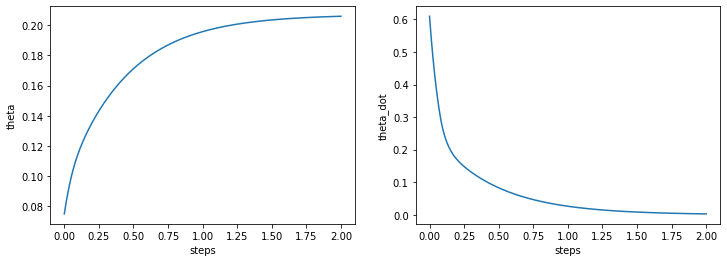

In [10]:
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
env.reset()
states = []
time_limit = 2
time_log = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    print(acc_time)
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

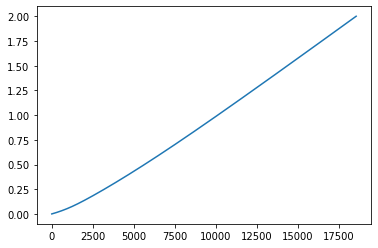

In [12]:
plt.plot(time_log)